# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [148]:
PATH = "./data/"

In [149]:
train_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
union = [train_data, test_data]

In [150]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [151]:
train_data.groupby('Sex').size()

Sex
female    314
male      577
dtype: int64

In [152]:
#Males Rate
train_data[train_data['Sex'] == 'male'].groupby('Survived').size()

Survived
0    468
1    109
dtype: int64

In [153]:
#Survival Rate in %
train_data.groupby(['Sex', 'Survived']).size()/train_data.groupby('Sex').size()*100

Sex     Survived
female  0           25.796178
        1           74.203822
male    0           81.109185
        1           18.890815
dtype: float64

<AxesSubplot:xlabel='Sex', ylabel='count'>

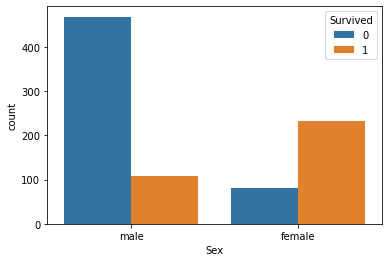

In [154]:
sns.countplot(x = train_data['Sex'], hue = train_data['Survived'])

As we can see, there is a fairly large relationship between gender and survival: only 18% of men survived, while among women this percentage is about 74%. 

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Average age:     29.7 
 Median age:     28.0


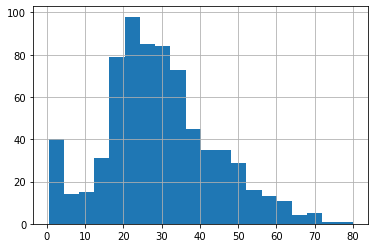

In [155]:
train_data['Age'].hist(bins = 20).plot()
print(f"Average age:{train_data['Age'].mean():9.1f} \n Median age:{train_data['Age'].median():9.1f}")

Text(0.5, 1.0, 'Survived age distribution (Green)')

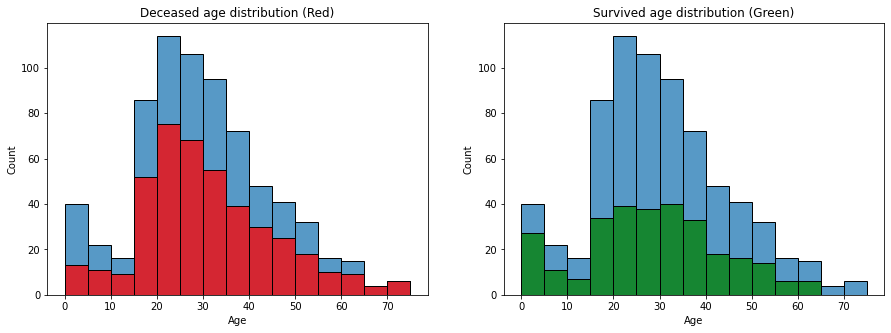

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

bin_values = np.arange(start=0, stop=train_data['Age'].max(), step=5)

sns.histplot(train_data, x = 'Age', ax = axes[0], bins = bin_values)
sns.histplot(train_data[train_data['Survived'] == 0], x = 'Age', ax = axes[0], color = 'red', bins = bin_values)
axes[0].set_title('Deceased age distribution (Red)')

sns.histplot(train_data, x = 'Age', ax = axes[1], bins = bin_values)
sns.histplot(train_data[train_data['Survived'] == 1], x = 'Age', ax = axes[1], color = 'green', bins = bin_values)
axes[1].set_title('Survived age distribution (Green)')

We can explore some usefull information: babies are much more likely to survive and older people are more likely to die - because of priority in salvation. Distribution of survived people is also much more "uniform-like".

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Text(0.5, 1.0, 'Port of Embarkation:')

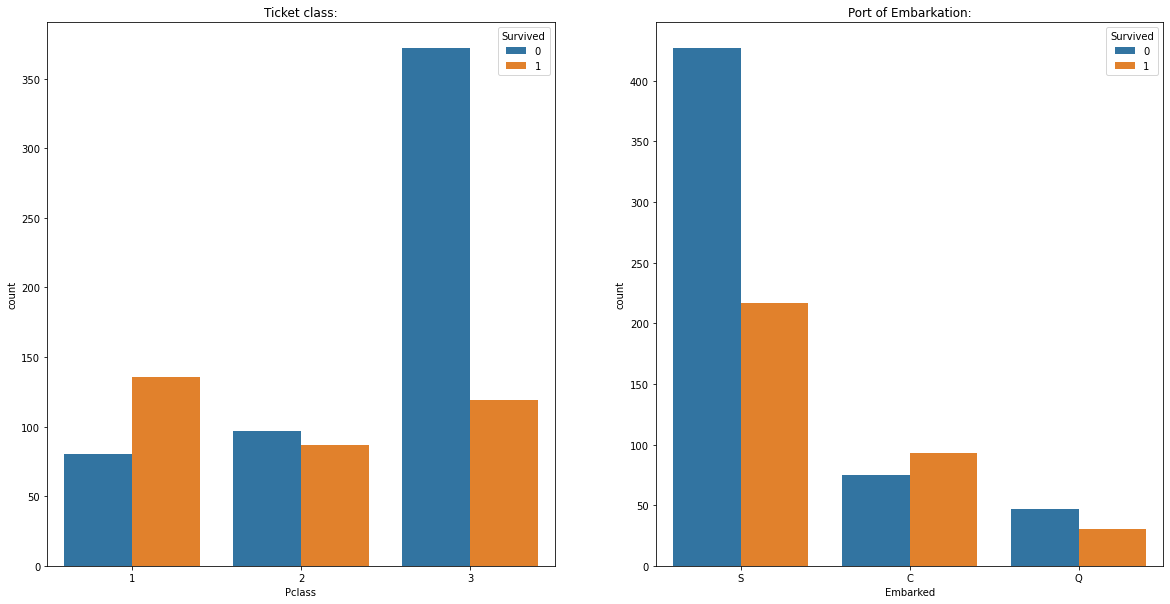

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.countplot(x="Pclass", hue="Survived", data=train_data, ax = axes[0])
axes[0].set_title('Ticket class:')
sns.countplot(x="Embarked", hue="Survived", data=train_data, ax = axes[1])
axes[1].set_title('Port of Embarkation:')

Well, seems like first class was the safest, followed by second. Third class was pretty much the deadly one.

People embarked in Cherbourg had more chances to survive than people from Queenstown and especcialy from Southampton. Sounds weird.. We can see why that took place by looking at Ticket Classes, that people bought on each port:

<AxesSubplot:xlabel='Pclass', ylabel='count'>

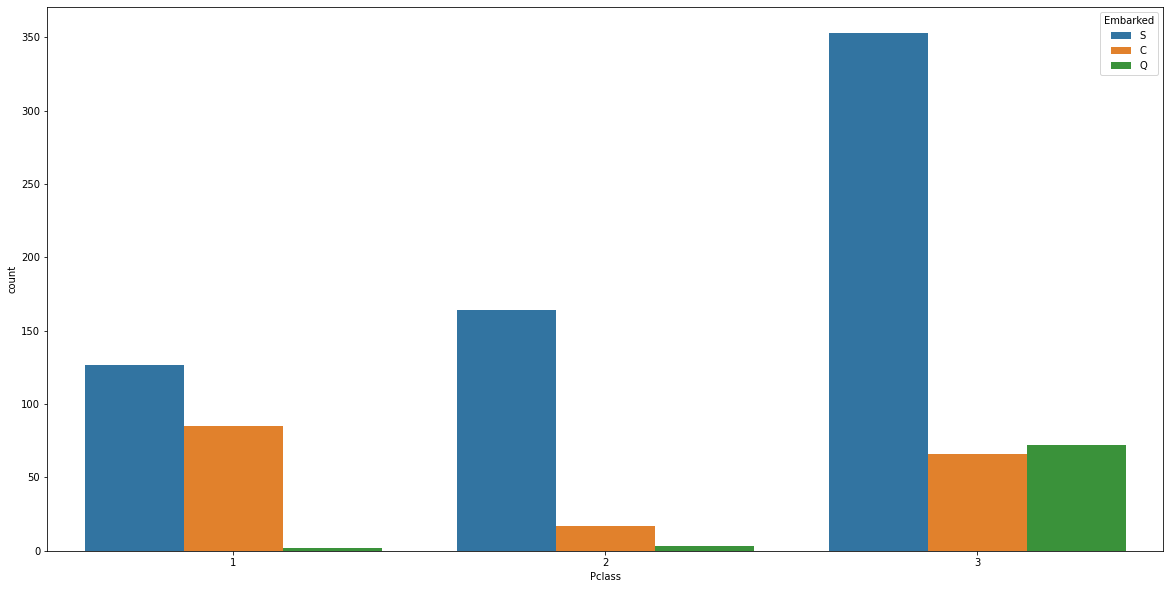

In [158]:
plt.subplots(1, figsize=(20, 10))
sns.countplot(x="Pclass", hue="Embarked", data=train_data)

Now it make sense: there were much more 1st class customers being launched in Cherbourg (in %). The Queenstown lags behind our logic a little, but note that its size is too small for such conclusions.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [159]:
train_data.isna().sum()/train_data.shape[0]*100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

In [160]:
test_data.isna().sum()/test_data.shape[0]*100

Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         20.574163
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.239234
Cabin       78.229665
Embarked     0.000000
dtype: float64

There are to much missing Cabin values - i will prefer to drop them. What adheres to the Age feature - we will create custom title feature - Mr and replace NaN values by median value in Mr corresponding cluster.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [161]:
train_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'))
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
dataset = train_data.append(test_data)

In [162]:
#removing missing Fare sample in test set by median value
dataset['Fare'].fillna(test_data['Fare'].dropna().median(), inplace=True)

In [163]:
# we will extract tittle from name as Mr column
import re
Pattern = re.compile(r', (\w+).')
Mr = []

for name in dataset['Name'].values:
    Mr.extend(Pattern.search(name).groups())

dataset["Mr"] = Mr

# Replacing rare titles with more common ones

mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 
           'Dona': 'Mrs', 'the': 'Mr', 'Rev': 'Mr'}

dataset.replace({'Mr': mapping}, inplace=True)

print(dataset.groupby('Mr').size())

Mr
Dr          8
Master     61
Miss      265
Mr        776
Mrs       199
dtype: int64


In [164]:
dataset['Age'] = dataset.apply(
                                lambda row: 
                                dataset[dataset['Mr'] == row['Mr']]['Age'].median() 
                                if np.isnan(row['Age']) 
                                else row['Age'], axis=1)

In [165]:
# We weill build feature Family_Survival based on the fact 
# either his family (according to the last name) has fully survived or not.

dataset['Last_Name'] = dataset['Name'].apply(lambda x: str.split(x, ",")[0])

DEFAULT_SURVIVAL_VALUE = 0.5
dataset['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for _, grp_df in dataset.groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with usefull family survival information:", 
      dataset.loc[dataset['Family_Survival']!=0.5].shape[0])

Number of passengers with usefull family survival information: 420


In [166]:
#Some of passengers did not travel with their families but with other kind of companions 
#So we should consider same-ticket groups in the same way we consider Family Survival groups

for _, grp_df in dataset.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with usefull family/group survival information: " 
      +str(dataset[dataset['Family_Survival']!=0.5].shape[0]))

Number of passenger with usefull family/group survival information: 546


In [167]:
# SEX one-hot
dataset['Sex'].replace(['male','female'],[0,1],inplace=True)

In [168]:
#SOME *FUTURE* FEATURE ENGINEERING

dataset['Baby'] = (dataset['Age'] < 6).astype(int)

dataset['Lost child'] =  (dataset['Mr'] == 'Master')*dataset['SibSp']/(dataset['Parch']+0.5)
    
dataset['IsWomanOrBaby'] = ((dataset.Sex == 1) | (dataset.Mr == 'Master')).astype(int)
    
dataset['FamilySize'] = (dataset.Parch + dataset.SibSp).astype(int)

In [169]:
# Making Bins for Fare

dataset['FareBin'] = pd.qcut(dataset['Fare'], 5)
label = LabelEncoder()
dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

dataset.drop(['Fare'], 1, inplace=True)

In [170]:
# Making Bins for Age

dataset['AgeBin'] = pd.qcut(dataset['Age'], 4)

label = LabelEncoder()
dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])

dataset.drop(['Age'], 1, inplace=True)

In [171]:
# dropping trash features
dataset.drop(['Name', 'SibSp', 'Last_Name', 'Mr', 'Parch', 'AgeBin', 'FareBin', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True) 

In [172]:
train_data = dataset[:891].drop(columns = ['PassengerId'])

test_indexes = dataset[891:]['PassengerId']
test_data = dataset[891:].drop(columns = ['PassengerId'])

train_data.head()

,Survived,Pclass,Sex,Family_Survival,Baby,Lost child,IsWomanOrBaby,FamilySize,FareBin_Code,AgeBin_Code
0,0.0,3,0,0.5,0,0.0,0,1,0,0
1,1.0,1,1,0.5,0,0.0,1,1,4,3
2,1.0,3,1,0.5,0,0.0,1,0,1,1
3,1.0,1,1,0.0,0,0.0,1,1,4,2
4,0.0,3,0,0.5,0,0.0,0,0,1,2


## FINALY, TESTING OUR KNN

In [181]:
np.random.seed(175)

features = train_data.drop(columns = 'Survived').columns

y = train_data['Survived']
X = train_data[features]

X_scaled = StandardScaler().fit_transform(X)
X.head()

,Pclass,Sex,Family_Survival,Baby,Lost child,IsWomanOrBaby,FamilySize,FareBin_Code,AgeBin_Code
0,3,0,0.5,0,0.0,0,1,0,0
1,1,1,0.5,0,0.0,1,1,4,3
2,3,1,0.5,0,0.0,1,0,1,1
3,1,1,0.0,0,0.0,1,1,4,2
4,3,0,0.5,0,0.0,0,0,1,2


In [208]:
# SequentialFeatureSelector. 
# At least we can see, that our custom features:
# 'Family_Survival', 'IsWomanOrBaby', 'AgeBin_Code'
# Are much more important than others.

neigh = KNeighborsClassifier(p = 2, n_neighbors=8)

selector = SequentialFeatureSelector(neigh, scoring='accuracy', n_jobs=-1, 
                                     direction = 'backward', n_features_to_select=4).fit(X_scaled, y)
X_pruned = selector.transform(X_scaled)

print('Selected features: ', list(X.columns[selector.get_support()]))
print('Score with All features:',cross_val_score(neigh, X_scaled, y, scoring='accuracy', cv=5).mean())
print('With important only:', cross_val_score(neigh, X_pruned, y, scoring='accuracy', cv=5).mean())

Selected features:  ['Pclass', 'Family_Survival', 'IsWomanOrBaby', 'AgeBin_Code']
Score with All features: 0.8305316678174629
With important only: 0.8596761031950285


In [210]:
# lets reconsider our feature-set based on Selector or our intuitions about the data.

features =  ['Pclass', 'Family_Survival', 'IsWomanOrBaby']
X = train_data[features]
X_scaled = StandardScaler().fit_transform(X)
#X_scaled = X_pruned

In [211]:
# lets find out what is the best parameter set for our model according to CV.

tuned_parameters = {'leaf_size': np.arange(5, 30), 
                     'n_neighbors': np.arange(5, 20),
                     'p': [2]}

clf = GridSearchCV(
        KNeighborsClassifier(algorithm='auto', metric='minkowski', metric_params=None, n_jobs=-1),
            scoring='accuracy', param_grid = tuned_parameters).fit(X_scaled, y)

print(clf.best_params_)
print(clf.best_score_)

{'leaf_size': 5, 'n_neighbors': 8, 'p': 2}
0.8563115937480384


## FINALY, SOME FIT-PREDICT

In [100]:
# PREPARING DATA FOR FINAL ESTIMATION
y_train = train_data['Survived'].astype(int)
X_train = train_data[features]
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test = test_data[features]
X_test_scaled = scaler.transform(X_test)

In [101]:
# SOLVING BY KNN
neigh = KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2)

neigh.fit(X_train_scaled, y_train)
y_pred = neigh.predict(X_test_scaled)

In [97]:
# SUBMITTION
submission = pd.DataFrame({
        "PassengerId": test_indexes,
        "Survived": y_pred
    })
submission.to_csv(os.path.join(PATH, 'titanic', 'submission0.csv'), index=False)

In [98]:
out = pd.read_csv(os.path.join(PATH, 'titanic', 'submission.csv'))
out

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
